In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn

In [2]:
df = pd.read_csv("../data/NaturalGasPrice/daily.csv")

In [3]:
df = df.dropna()

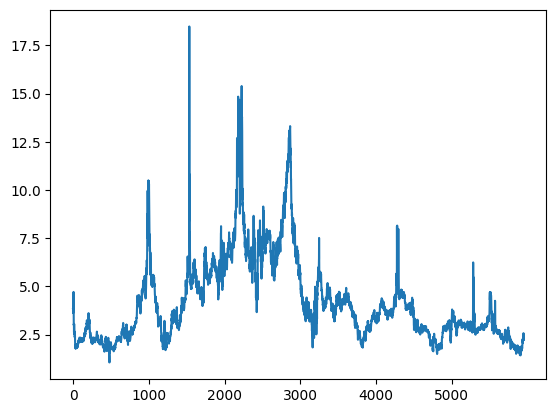

In [4]:
plt.plot(df['Price'])
plt.xticks(range(0, len(df['Price']), 1000))
plt.show()

In [5]:
y = df['Price'].values
x = np.arange(1, len(y), 1)

In [6]:
print(len(y))

5952


In [7]:
minm = y.min()
maxm = y.max()

y = (y - minm) / (maxm - minm)

In [8]:
Sequence_Length = 20

In [9]:
X = []
Y = []
for i in range(0, len(y) - Sequence_Length):
    list1 = []
    for j in range(i, i + Sequence_Length):
        list1.append(y[j])
    X.append(list1)
    Y.append(y[j + 1])

In [10]:
X = np.array(X)
Y = np.array(Y)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(
    X, 
    Y, 
    test_size=0.10, 
    shuffle=False, 
    stratify=None
)

In [12]:
class NGTimeSeries(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.len = x.shape[0]
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return self.len

In [13]:
dataset = NGTimeSeries(x_train, y_train)

In [14]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset, shuffle=True, batch_size=128)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel,self).__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=5, num_layers=2, nonlinearity='relu', batch_first=True)
        self.fc = nn.Linear(in_features=5, out_features=1)
    
    def forward(self, x):
        output, _status = self.rnn(x)
        output = output[:, -1, :]
        output = self.fc(torch.relu(output))
        return output

In [17]:
model = RNNModel().to(device)

In [18]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 1500

In [19]:
loss_list = []

for i in range(epochs):
    for j, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(-1, Sequence_Length, 1)
        y_pred = model(data).reshape(-1)
        loss = criterion(y_pred, target)
        loss.backward()
        optimizer.step()
    
    if i % 100 == 0:
        print(i, "th iteration : ", loss.item())

0 th iteration :  0.019728491082787514
100 th iteration :  0.02046775445342064
200 th iteration :  0.005973002873361111
300 th iteration :  0.004573033191263676
400 th iteration :  0.006648095790296793
500 th iteration :  0.0005402657552622259
600 th iteration :  0.001973256468772888
700 th iteration :  0.0005506973247975111
800 th iteration :  0.002608471317216754
900 th iteration :  0.00437646359205246
1000 th iteration :  0.007188746239989996
1100 th iteration :  0.0020993067882955074
1200 th iteration :  0.0011678400915116072
1300 th iteration :  0.002205696189776063
1400 th iteration :  0.0026306675281375647


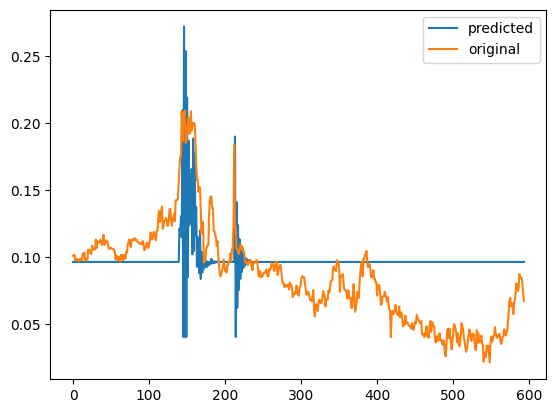

In [20]:
test_set = NGTimeSeries(x_test,y_test)
test_pred = model(test_set[:][0].view(-1,Sequence_Length,1).to(device)).view(-1)

plt.plot(test_pred.cpu().detach().numpy(),label='predicted')
plt.plot(test_set[:][1].view(-1),label='original')
plt.legend()
plt.show()